In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactuals evaluation for the GSMarena dataset

We decided to evaluate the data in 2 separate sets, the correctly predicted samples by the neural network and the misclassified ones. For the ***former*** we can compute the following counterfactuals:
- from low-price to medium-price
- from medium-price to low-price and to high-price
- from high-price to medium-price.

While if a sample was misclassified by the model, we generate the counterfactual to obtain the correct class. For some samples the OMLT and the DiCE models are not able to find a valid counterfactual within the time limit.

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
import torch

from utils.util_base_cf import inverse_pipeline
import utils.util_evaluation as util_evaluation
from utils import util_counterfactual
from utils.util_models import get_correct_wrong_predictions, NNClassification
from utils import util_plot

In [3]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [4]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

kaggle.json not found, you cannot use kaggle module.


Check the number of samples that we will test.

In [5]:
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_test_den = inverse_pipeline(cols_pipeline, df_test)
df_test_den = df_test_den.astype({"num_main_camera": float})
df_test_den = util_evaluation.cast_round_type(df_test_den, df_test_den.dtypes.to_dict())
print(f"Number of samples in test set: {len(df_test_den)}")

Number of samples in test set: 383


In [6]:
# The name of the features used during training and for counterfactual generation
feature_columns = df_test_den.columns.drop(["misc_price_min", "misc_price_max"])
print(f"Feature columns: {feature_columns.tolist()}")

Feature columns: ['display_size', 'battery', 'memory_ram_gb', 'memory_rom_gb', 'main_camera_resolution', 'selfie_camera_resolution', 'display_resolution', 'network_technology', 'num_main_camera', 'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers', 'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging', 'is_waterproof']


Load the neural network with the best weights.

In [7]:
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

# Import the model
num_features = X_test.shape[1]
num_class = len(np.unique(y_test))
hidden_layers = [64, 64]
model_path = "models/nn_model.pt"

nn_model = NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=0)

checkpoint = torch.load(model_path)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [8]:
corr_ind, wrong_ind = get_correct_wrong_predictions(nn_model, X_test, y_test)
print(f"The correctly predicted samples are {len(corr_ind)}/{len(X_test)}.")

The correctly predicted samples are 287/383.


Find how many valid counterfactuals have been found for correctly predicted samples.

In [9]:
low_high_corr_idx = y_test[(y_test == 0) | (y_test == 2)].index.intersection(corr_ind)
medium_corr_idx = y_test[y_test == 1].index.intersection(corr_ind)

number_of_correct = low_high_corr_idx.shape[0] + 2 * medium_corr_idx.shape[0]

In [10]:
# Columns to ignore when we quantify feature changes
ignore_cols = ["misc_price_min", "misc_price_max", "display_resolution", "network_technology", 
               "has_oled_display", "has_memory_card_slot", "has_stereo_speakers", "has_3.5mm_jack", 
               "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]

## Evaluation on correctly predicted samples

In this section we will analyze the performance of the counterfactual generation on samples that are correctly predicted by our model.

To compute the differences from the original samples, we need to import the dataframe with test data and we have to denormalize them. In the imported dataset we have some features that are not numbers, therefore we first have to do a simple remapping (like a LabelEncoding) from strings to the number that represents that text.

We also need to import the training data to compute some statistics and proceed with our analysis.

In [11]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)

# Denormalize the data and keep only necessary columns
df_train = inverse_pipeline(cols_pipeline, df_train)
df_train = df_train.astype({"num_main_camera": float})
print(f"Number of samples in training set: {len(df_train)}")

Number of samples in training set: 1521


### OMLT

Read the counterfactuals generated by Omlt on the test set.

In [12]:
df_cf_omlt_corr = pd.read_csv("data/counterfactual/corr_cf_omlt.csv", index_col=0)
df_cf_omlt_corr = util_evaluation.cast_round_type(df_cf_omlt_corr, df_test_den.dtypes.to_dict())

Among the correctly predicted counterfactuals (287), the OMLT model was able to produce 377 valid counterfactual. The value is larger than the total number of correctly predicted samples because for the medium range we generated the counterfactual for both the lower and the higher ranges.

In [13]:
print(f"Number of counterfactuals found by OMLT: {df_cf_omlt_corr.index.shape[0]}/{number_of_correct}")

Number of counterfactuals found by OMLT: 377/382


In the following cell we can check for which sample the model was not able to find a valid counterfactual.

In [73]:
failed_corr_omlt = util_evaluation.get_failed_index(df_cf_omlt_corr, pd.Index(corr_ind), medium_corr_idx, [40,  215, 420])
df_test_den.loc[failed_corr_omlt]

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
372,215.0,420.0,5.5,2870.0,3.0,32.0,21.0,8.0,FHD,4G,1.0,1,1,0,1,1,0,0,0
450,215.0,420.0,4.0,1624.0,2.0,16.0,12.0,2.0,HD,4G,1.0,0,0,0,1,1,1,0,0
1806,215.0,420.0,5.1,2550.0,3.0,32.0,16.0,5.0,QHD,4G,1.0,1,0,0,1,1,1,1,0
1851,215.0,420.0,5.5,3000.0,3.0,32.0,16.0,8.0,QHD,4G,1.0,0,1,0,1,1,1,1,0


At this point we merge the counterfactuals with the test dataset with an inner join and we set the features with the same value of the original sample to Nan. In this way we can quickly find all the features changed in the counterfactuals. 

In [14]:
merge_df_omlt_corr = util_evaluation.join_merge_columns(df_cf_omlt_corr, df_test_den, ["misc_price_min", "misc_price_max"])

We show the number of features changed by OMLT to generate the valid counterfactuals.

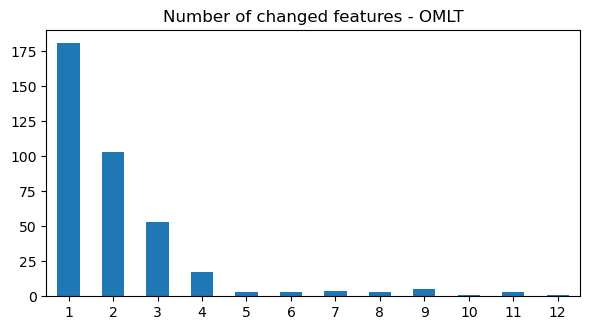

In [17]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="changed_feat", 
    plot_title="Number of changed features - OMLT", split_ranges=False, figsize=(6, 3.4))

We can deduct, from the previous graph, that the **average number** of features changed by Omlt is around 2. 

This means that the model is able to find good solutions, counterfactuals with changed labels (valid) and for which only few features are different from the original sample.

The average time required by the OMLT model to compute a counterfactual is around 24 seconds.

**Split the ranges**

In this other case we consider the charts for each change from one range to another, such that we can conduct a fine-grained analysis on the different ranges.

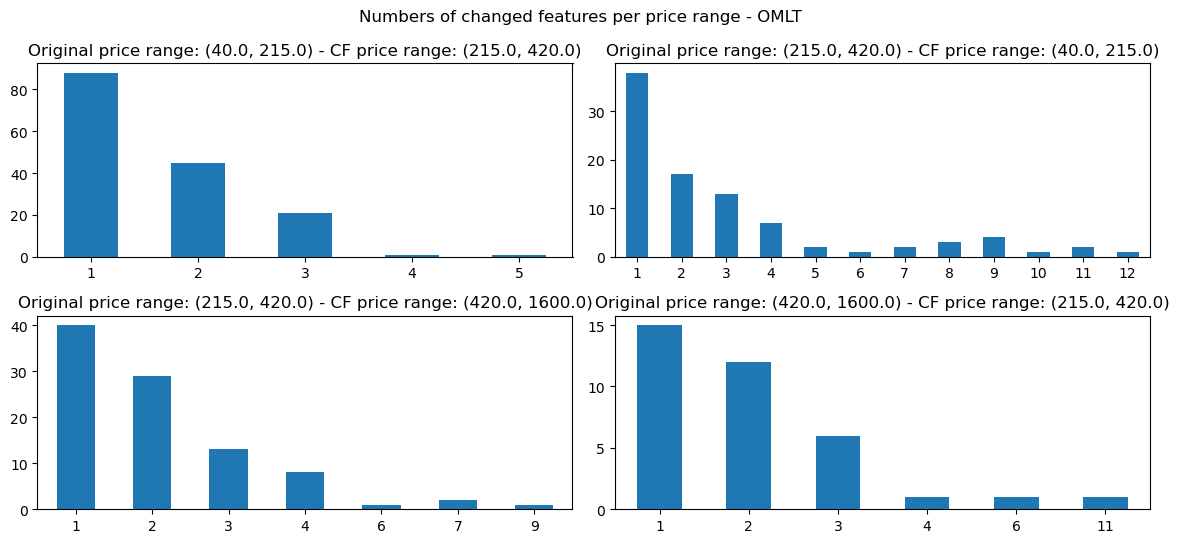

In [27]:
util_evaluation.plot_cfs_stats(merge_df_omlt_corr, feature_columns=None, plot_mode="changed_feat", 
                               split_ranges=True, plot_title="Numbers of changed features per price range - OMLT", 
                               figsize=(11.7, 5.5))

Looking at the subplots, we can notice that passing from low to medium range seems to be the easiest process for the model, the maximum number of changed features is 5 indeed. 

It's more difficult for the model to change the label from medium to low range and from medium to high range, it may require up to 12 changed features. We also need to keep in mind that these results are affected by the timelimit (60 seconds) we set and by the random process used to sample candidates.



**Changes per feature**

After that we observed the general distribution of the changes performed by the OMLT model in order to generate counterfactuals, we also show which features are the most modified.

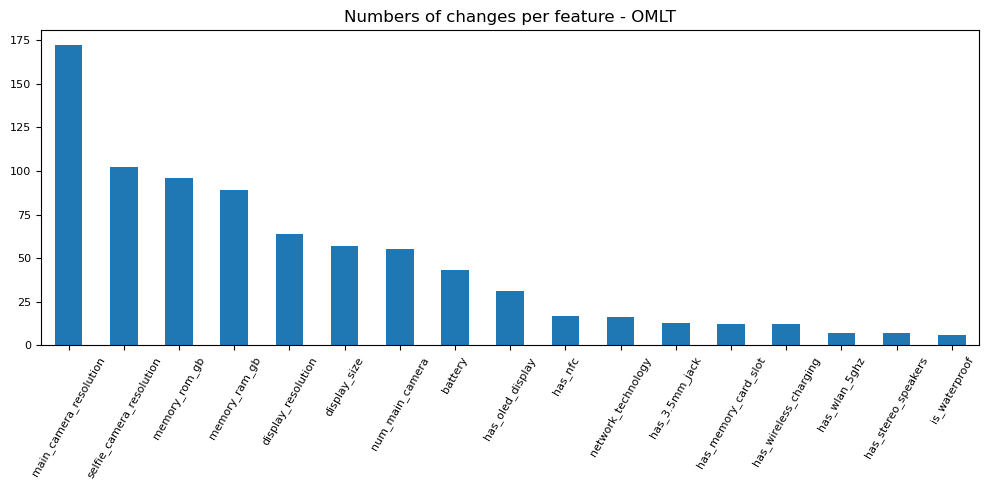

In [37]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Numbers of changes per feature - OMLT", figsize=(10, 5), fontsize=8)

Another interesting chart that we can plot, it's the one representing how many times each feature has been changed during the counterfactuals generation, such that we can discover which features are the most useful to change the price range of a device.

For the OMLT model the most important features seem to be ***main_camera_resolution***, ***selfie_camera_resolution***, ***memory_rom_gb***, ***memory_ram_gb*** and ***display_resolution***.

**Changes per feature (different ranges)**

Also in this case we want to check if some features are more useful than others for changing the label from one price range to another.

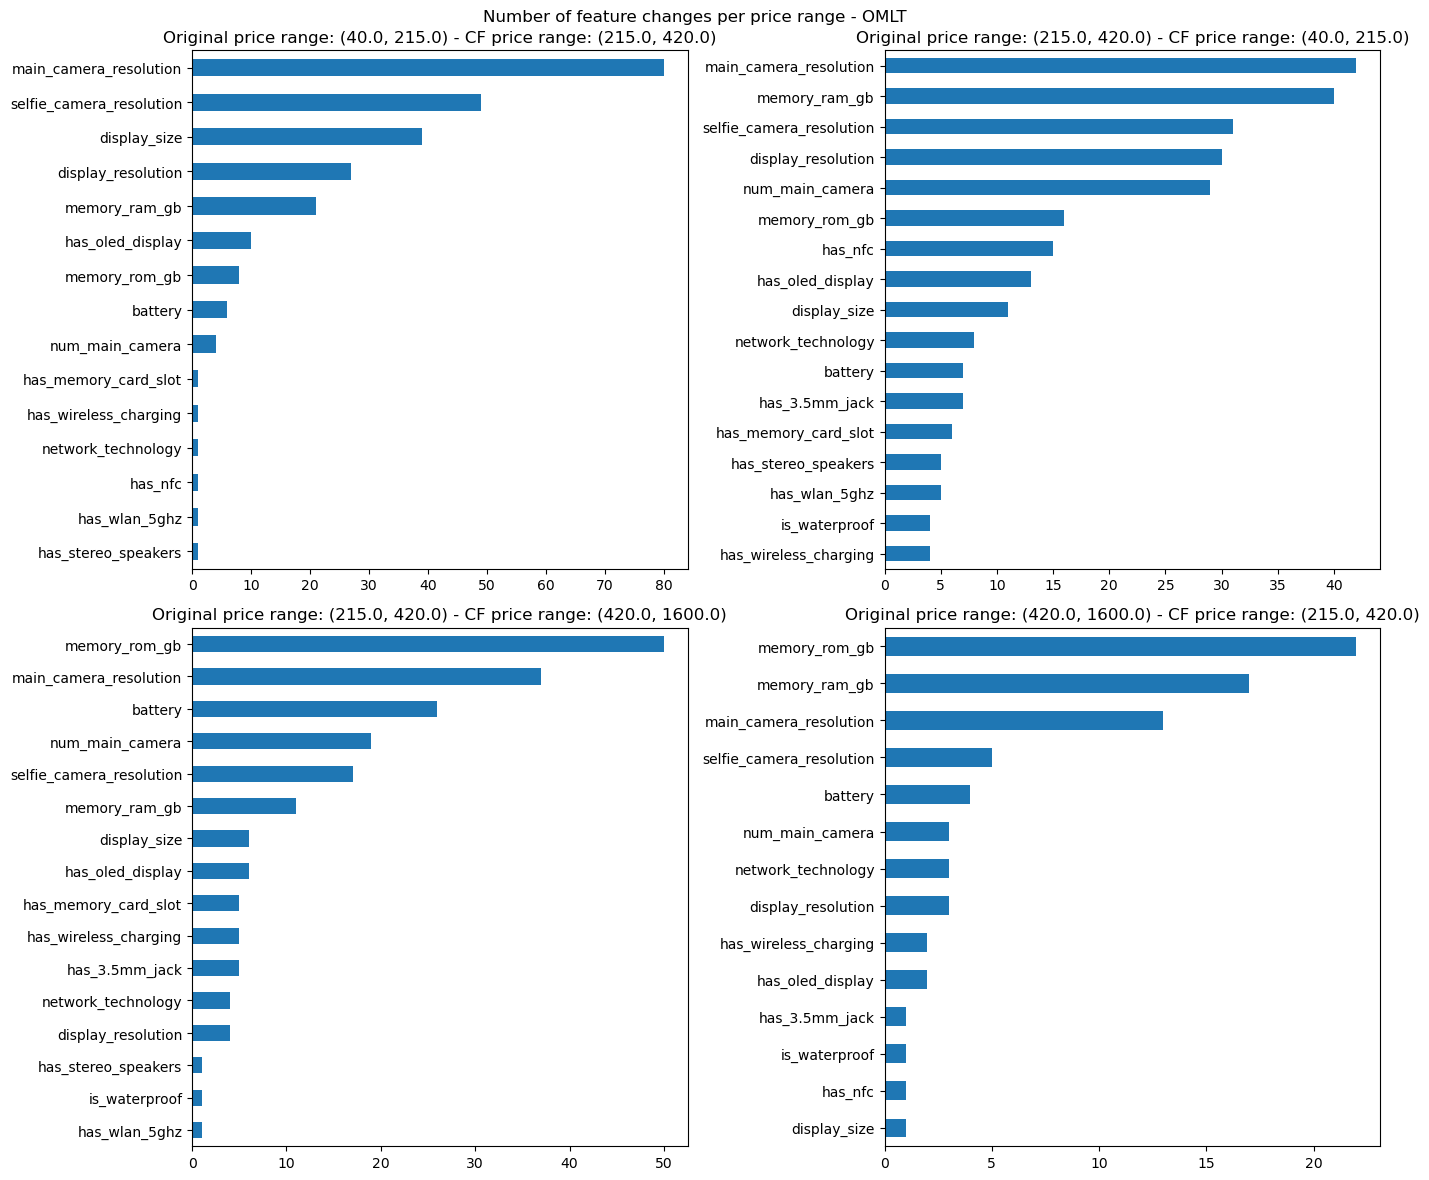

In [39]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of feature changes per price range - OMLT", figsize=(14, 12)
)

The most changed features to pass from a low-range device to a medium one are the **cameras** and the **display size**. To pass from a higher to a lower range the **memory rom** and the **memory ram** seem predominant.  

**Quantify the feature changes**

So far we only analyzed the number of changed features or the number of changes for each feature, but we have not considered yet how much these features changed. 

In the following cell we plot the relative changes, in percentage, for the non-binary features, adding the increments and decrements together to have a general view.

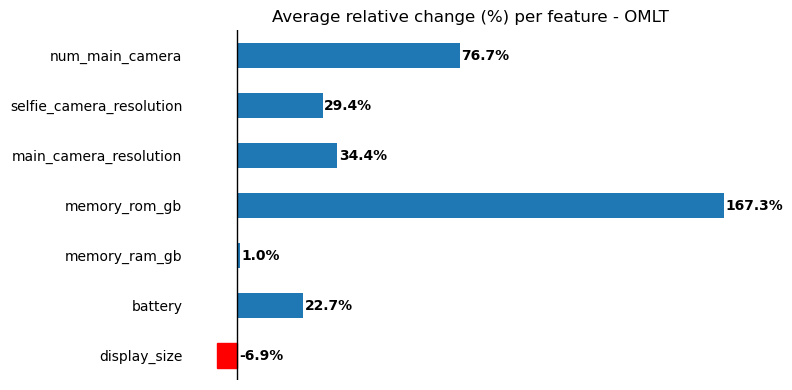

In [56]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="relative_change", split_ranges=False,
    plot_title="Average relative change (%) per feature - OMLT", figsize=(8, 4), ignore_cols=ignore_cols
)

**Split relative changes per range**

As for the previous graphs, also in this case we want to show the different changes performed for the ranges.

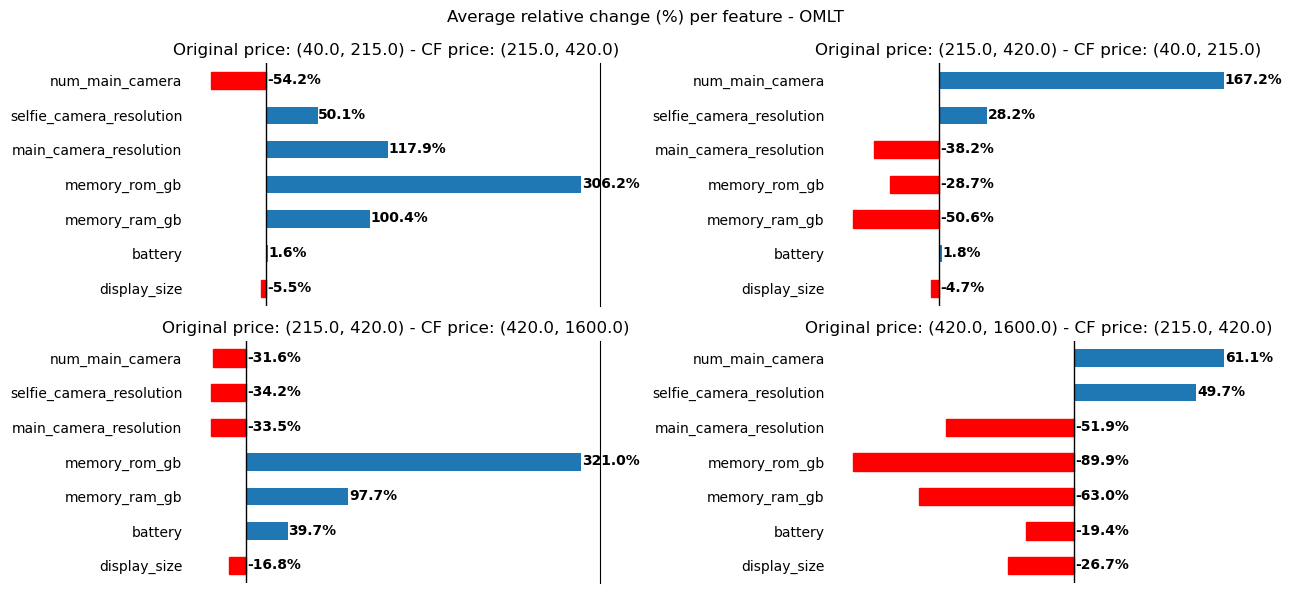

In [65]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="relative_change", split_ranges=True,
    plot_title="Average relative change (%) per feature - OMLT", figsize=(13, 6), ignore_cols=ignore_cols)

The OMLT model consistently increases the ***memory_rom_gb*** feature when it needs to pass from a lower to a higer price range, while it decreases a lot of features when it must decrease the price range, as expected.

All the counterfactuals have been generated using the same weights for each feature, therefore we did not act on the model to counteract this behaviour, but in the last section we will perform some tests changing the feature weights.

### Dice

In this other section we want to check how Dice generated the counterfactuals for the correctly predicted samples.

In [68]:
df_cf_dice_corr = pd.read_csv("data/counterfactual/corr_cf_dice.csv", index_col=0)
df_cf_dice_corr = util_evaluation.cast_round_type(df_cf_dice_corr, df_test_den.dtypes.to_dict())
df_cf_dice_corr.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.2737,3500.0,3.0,32.0,16.0,8.0,FHD,4G,3.0,0,1,0,1,1,1,0,0
1861,40.0,215.0,5.5000,3000.0,1.0,32.0,12.0,8.0,FHD,4G,1.0,0,1,0,1,1,1,0,0
1339,40.0,215.0,6.0061,3500.0,3.0,32.0,16.0,16.0,HD,4G,2.0,1,1,0,1,0,0,0,0
664,215.0,420.0,6.0061,4100.0,3.0,64.0,13.0,5.0,FHD,4G,1.0,0,1,0,1,1,0,0,0
918,40.0,215.0,5.5000,3000.0,3.0,32.0,13.0,8.0,FHD,4G,1.0,0,1,0,1,1,0,0,0


In [203]:
print(f"Number of counterfactuals found by DiCE: {df_cf_dice_corr.shape[0]}/{number_of_correct}")

Number of counterfactuals found by DiCE: 377/382


Check, also for DiCE, which are the samples for which it was not able to find a valid counterfactual.

In [204]:
failed_corr_dice = util_evaluation.get_failed_index(df_cf_dice_corr, pd.Index(corr_ind), medium_corr_idx, [40,  215, 420])
df_test_den.loc[failed_corr_dice]

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
102,420.0,1600.0,6.20,3600.0,6.0,128.0,48.0,20.0,FHD,4G,2.0,1,0,0,0,1,1,0,0
372,215.0,420.0,5.50,2870.0,3.0,32.0,21.0,8.0,FHD,4G,1.0,1,1,0,1,1,0,0,0
689,215.0,420.0,5.20,3100.0,3.0,16.0,20.0,8.0,FHD,4G,1.0,0,1,0,1,1,0,0,0
1818,215.0,420.0,5.20,3100.0,3.0,16.0,21.0,3.0,FHD,4G,1.0,0,1,1,1,1,1,0,1
1889,215.0,420.0,6.26,3750.0,6.0,128.0,48.0,32.0,FHD,4G,4.0,0,0,0,0,1,1,0,0


As in the section before, we compute the merge between the test dataframe and the one that contains the counterfactuals generated by Dice.

In [69]:
merge_df_dice_corr = util_evaluation.join_merge_columns(df_cf_dice_corr, df_test_den, ["misc_price_min", "misc_price_max"])

First of all we plot a generic chart that shows the number of changed features for the generated counterfactuals.

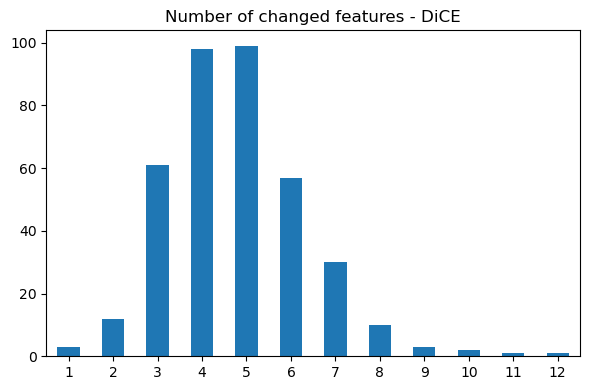

In [70]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - DiCE", split_ranges=False, figsize=(6,4))

Then we check if there are some ranges that are more difficult to change.

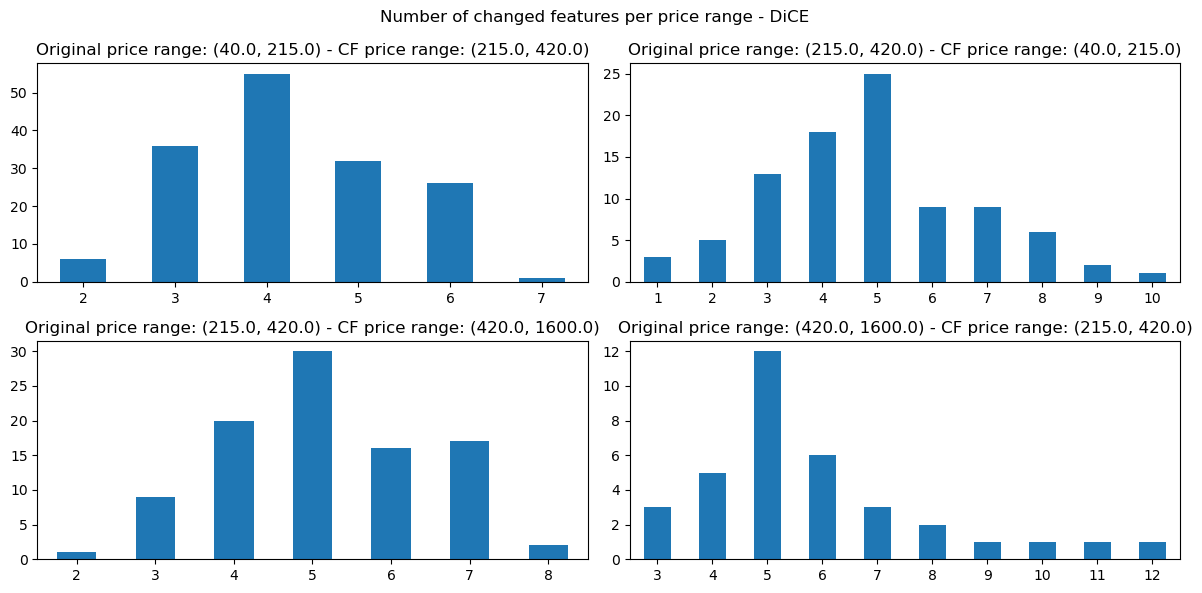

In [71]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - DiCE", figsize=(12, 6))

We can notice that DiCE, in general, generate counterfactuals changing more features than OMLT, but we will see later if they are of a higher quality.

As for OMLT, we plot the number of changes occured for each feature.

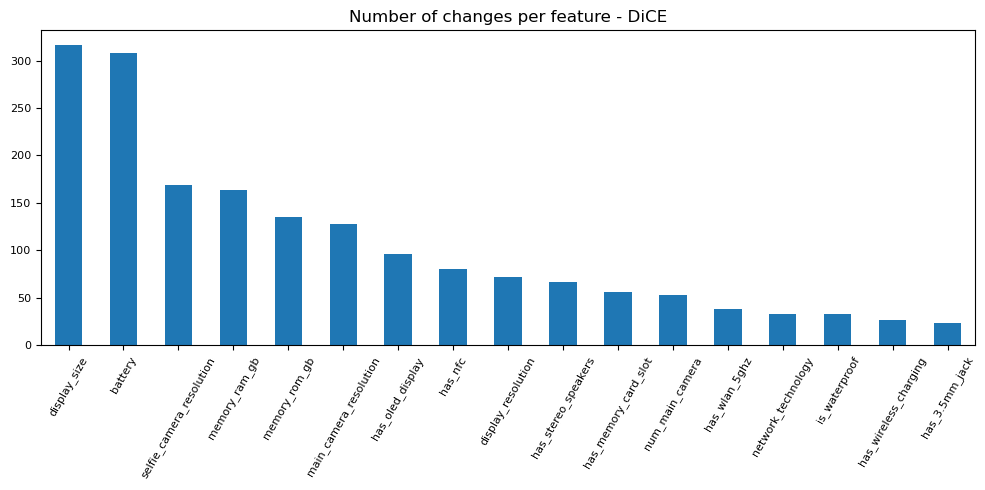

In [72]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - DiCE", figsize=(10, 5), fontsize=8)

It is interesting to see that DiCE changed more some features that are less considered by OMLT, this difference is due to the 2 different approaches used for the optimization process. One main difference is that we used a genetic algorithm with DiCE, while we proceed using random sampling with OMLT.

Moreover all the most changed features by DiCE are also in the top 8 most changed features by OMLT, therefore the data does not differ much.

We want to check if some features are more useful than others for changing the label from one price range to another.

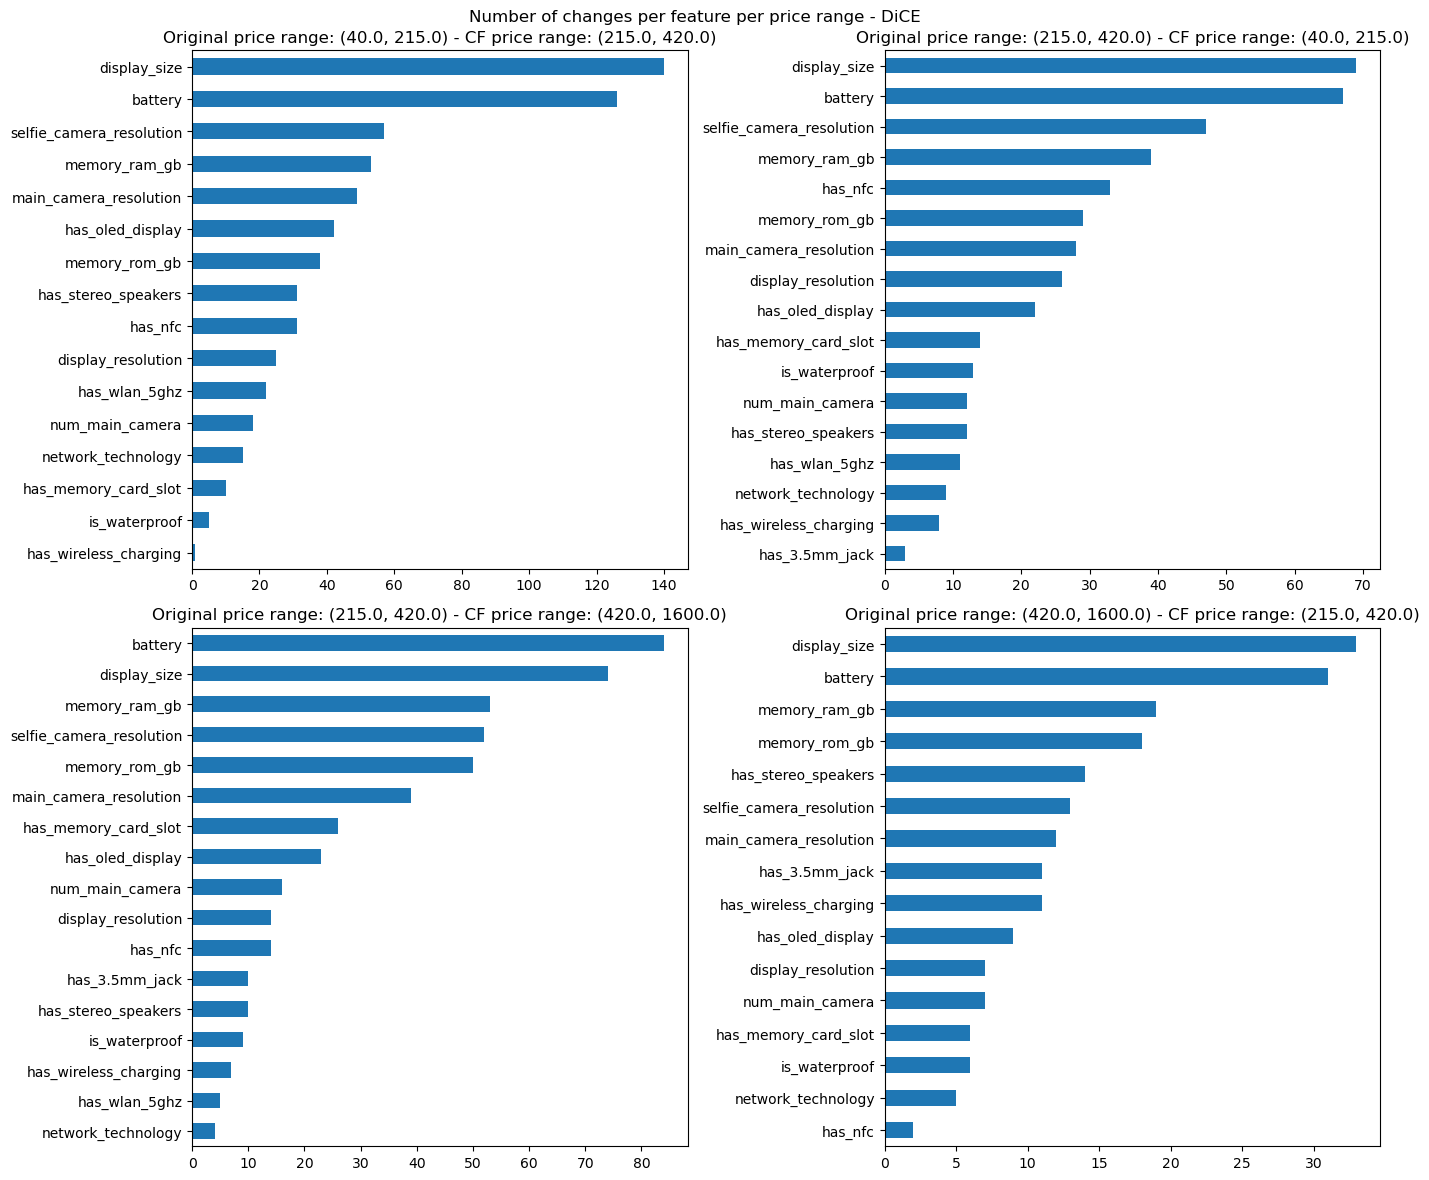

In [80]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - DiCE", figsize=(14, 12)
)

**Quantify the feature changes**

In the last graphs we show the relative changes, in percentage, for each non-binary feature. In this way we may check numerically how DiCE worked during the generation of the counterfactuals.

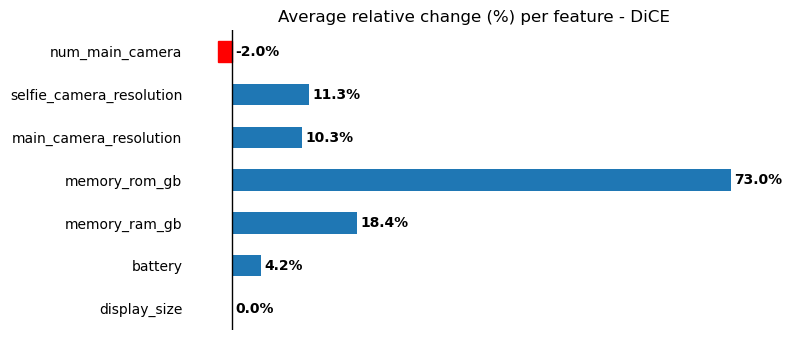

In [77]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="relative_change", split_ranges=False,
    plot_title="Average relative change (%) per feature - DiCE", figsize=(8, 3.5), ignore_cols=ignore_cols)

Even if **display_size** is the most changed feature, the total change is 0, it means that DiCE has changed the features in a balanced way in the different ranges.

**Split relative changes per range**

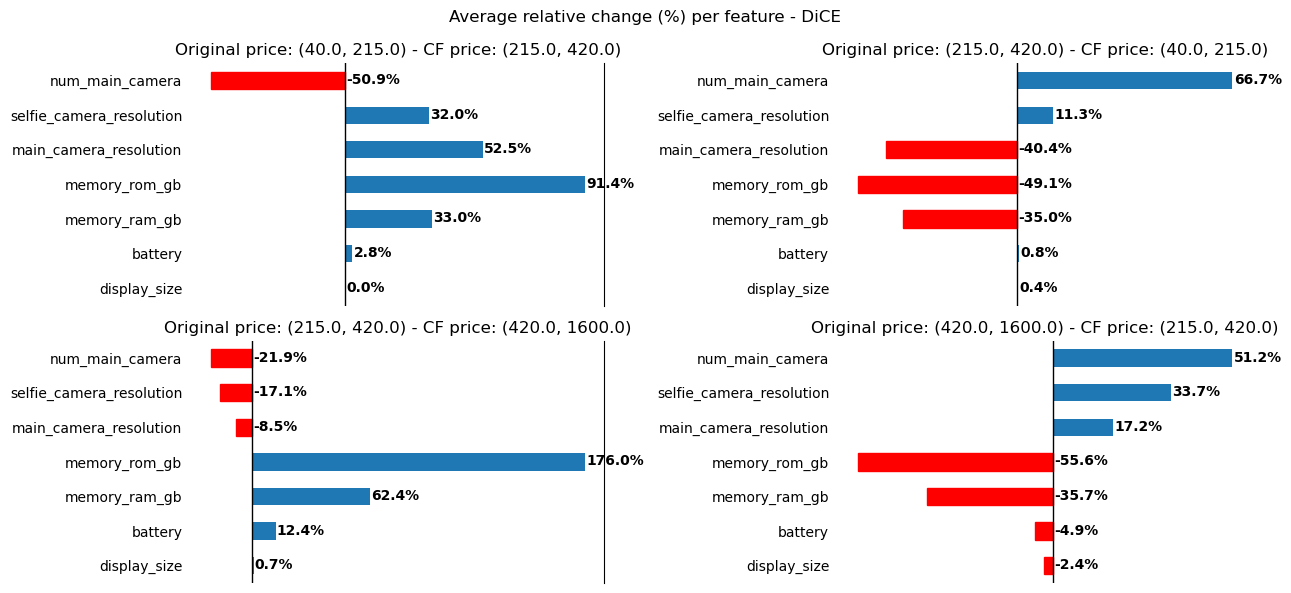

In [78]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="relative_change", split_ranges=True,
    plot_title="Average relative change (%) per feature - DiCE", figsize=(13, 6), ignore_cols=ignore_cols)

As we can see, also in this case the **memory_rom_gb** feature is the one changed the most.

**battery** and **display_size** are the most changed features, as shown before, and this is probably because DiCE performed very tiny changes to them on a lot of samples.

### Compute closest devices to the generated counterfactuals

The last value we want to compute is the distance of the generated counterfactuals from the original samples (the training dataset). With this value we can understand how similar the counterfactuals are to real devices, and it may be indicative of the quality of the counterfactual model.

In [79]:
def get_training_pipeline(df_train: pd.DataFrame, ordinal_encoding: dict = None, num_cols: list = None):
    df_train = df_train.copy()

    pipeline = list()
    # Ordinal pipeline
    if ordinal_encoding is not None:
        ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=list(ordinal_encoding.values()), dtype=np.int64))
        ordinal_pipeline.set_output(transform="pandas")
        ordinal_columns = list(ordinal_encoding.keys())
        df_train[ordinal_columns] = ordinal_pipeline.fit_transform(df_train[ordinal_columns])
        pipeline.append((ordinal_columns, ordinal_pipeline))

    # Numerical pipeline
    if num_cols is not None:
        num_pipeline = make_pipeline(MinMaxScaler((0, 1)))
        num_pipeline.set_output(transform="pandas")
        df_train[num_cols] = num_pipeline.fit_transform(df_train[num_cols])
        pipeline.append((num_cols, num_pipeline))

    return pipeline


def apply_pipeline(pipeline: list, df: pd.DataFrame, drop_cols: list = None, rename_cols: dict = None):
    df = df.copy()
    for (cols, pipe) in pipeline:
        df[cols] = pipe.transform(df[cols])

    df = df.drop(drop_cols, axis=1)
    df = df.rename(columns=rename_cols)

    assert df.dtypes.apply(lambda x: x in [np.int64, np.float64]).all()
    return df


In [80]:
ordinal_encoding = {
    "display_resolution": ["qHD", "HD", "FHD", "QHD"],
    "network_technology": ["3G", "4G", "5G"],
    "misc_price_min": [40, 215, 420]
}
numerical_cols = df_train.columns.drop(["misc_price_min", "misc_price_max"]).to_list()

pipeline = get_training_pipeline(df_train, ordinal_encoding, numerical_cols)

We need to take the data and to apply the pipeline to have the values needed for the analysis.

In [81]:
drop_cols = ["misc_price_max"]
rename_cols = {"misc_price_min": "misc_price"}

df_train_enc = apply_pipeline(pipeline, df_train, drop_cols, rename_cols)
df_test_enc = apply_pipeline(pipeline, df_test_den, drop_cols, rename_cols)
df_dice_enc = apply_pipeline(pipeline, df_cf_dice_corr, drop_cols, rename_cols)
df_omlt_enc = apply_pipeline(pipeline, df_cf_omlt_corr, drop_cols, rename_cols)

In the following test we compute for each sample, the most similar device, if the distance is above a threshold then we consider the sample as not similar.

**Training similarity**

First of all we compute the similarity between the samples of the training dataset, to check how similar the devices are.

In [82]:
similar_df = df_train_enc.apply(lambda x: util_evaluation.compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_train_enc.shape[0]

In [83]:
print(f"Number of similar samples in training dataset: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar samples in training dataset: 1500 out of 1521 (98.62%)


**Test similarity**

We compute the same value between the samples in the test set and the ones in the training set.

In [84]:
similar_df = df_test_enc.apply(lambda x: util_evaluation.compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_test_enc.shape[0]

In [86]:
print(f"Number of test samples similar to training samples: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of test samples similar to training samples: 382 out of 383 (99.74%)


**DiCE similarity**

In [87]:
similar_df = df_dice_enc.apply(lambda x: util_evaluation.compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_dice_enc.shape[0]

In [89]:
print(f"Number of similar counterfactuals generated by DiCE: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar counterfactuals generated by DiCE: 374 out of 377 (99.20%)


**OMLT similarity**

In [90]:
similar_df = df_omlt_enc.apply(lambda x: util_evaluation.compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_omlt_enc.shape[0]

In [91]:
print(f"Number of similar counterfactuals generated by OMLT: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar counterfactuals generated by OMLT: 333 out of 377 (88.33%)


We observe from the data that DiCE created very good counterfactuals, most of them similar to existent devices, while OMLT struggles a bit on this statistic. 

A possible explanation is that we did not consider an objective function to generate counterfactuals that are close to the distribution of the original data. DiCE, using a genetic algorithm, probably move along that distribution instead of taking random samples as a starting point.

We can see an example for the most similar devices found for a specific sample.

In [91]:
idx = 314
print("The considered counterfactual is:")
samples = df_dice_enc.loc[[idx]]
display(samples)
print("The most similar is:")
most_similar_sample = samples.apply(lambda x: util_evaluation.compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)

for i, sim_idx in enumerate(most_similar_sample.values):
    print(f"---{sim_idx}---")
    original_sample: pd.Series = df_cf_dice_corr.loc[idx].iloc[i]
    similar_sample: pd.Series = df_train.loc[sim_idx]
    print(f"The label of the counterfactual is {original_sample.misc_price_min}-{original_sample.misc_price_max}.")
    print(f"The label of the most similar sample is {similar_sample.misc_price_min}-{similar_sample.misc_price_max}.\n")

The considered counterfactual is:


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,0,0.691233,0.246575,0.181818,0.111111,0.132075,0.162791,0.666667,0.5,0.666667,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
314,2,0.691233,0.236986,0.454545,0.492063,0.132075,0.441860,0.666667,0.5,0.333333,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


The most similar is:
---132---
The label of the counterfactual is 40.0-215.0.
The label of the most similar sample is 40.0-215.0.

---1203---
The label of the counterfactual is 420.0-1600.0.
The label of the most similar sample is 420.0-1600.0.



## Evaluation on misclassified samples

We performed the same analysis as before (a reduced version) but focused on the misclassified samples of the test dataset. In this case we changed the label from the wrong one (predicted by the NN) to the groundtruth.

### OMLT

In [92]:
df_cf_omlt_mis = pd.read_csv("data/counterfactual/wrong_cf_omlt.csv", index_col=0)
df_cf_omlt_mis = util_evaluation.cast_round_type(df_cf_omlt_mis, df_test_den.dtypes.to_dict())
df_cf_omlt_mis.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
868,215.0,420.0,5.50,4070.0000,4.0,8.0,16.0,8.0,FHD,4G,1.0,0,0,1,0,1,1,0,0
771,420.0,1600.0,6.40,3750.0000,6.0,128.0,19.0,25.0,FHD,4G,2.0,0,0,0,1,1,0,0,0
1672,215.0,420.0,5.50,4310.5632,4.0,64.0,13.0,16.0,HD,4G,1.0,1,1,0,1,1,0,0,0
1597,40.0,215.0,5.99,4000.0000,2.0,64.0,12.0,20.0,FHD,4G,2.0,0,1,0,1,1,0,0,0
1030,215.0,420.0,5.46,2868.0575,4.0,64.0,12.0,20.0,FHD,4G,2.0,1,0,1,1,1,0,0,0


In [94]:
print(f"Number of counterfactuals found by OMLT for misclassified samples: {df_cf_omlt_mis.shape[0]}/{len(wrong_ind)}")

Number of counterfactuals found by OMLT for misclassified samples: 96/96


In [95]:
merge_df_omlt_mis = util_evaluation.join_merge_columns(df_cf_omlt_mis, df_test_den, ["misc_price_min", "misc_price_max"])

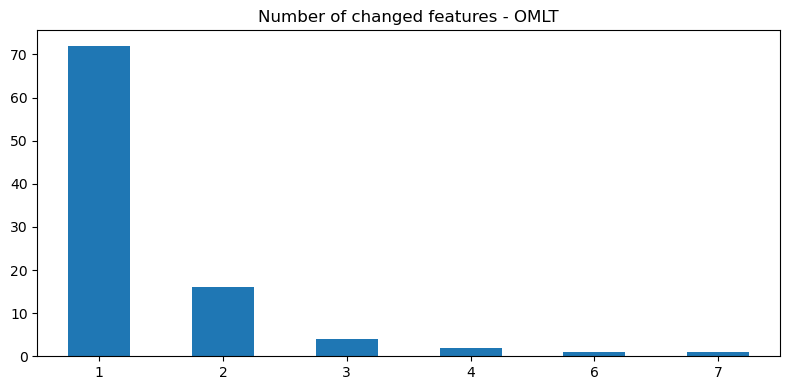

In [107]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - OMLT", split_ranges=False, figsize=(8,4)
)

The number of changed features is lower than before, because the problem is simplier than before.

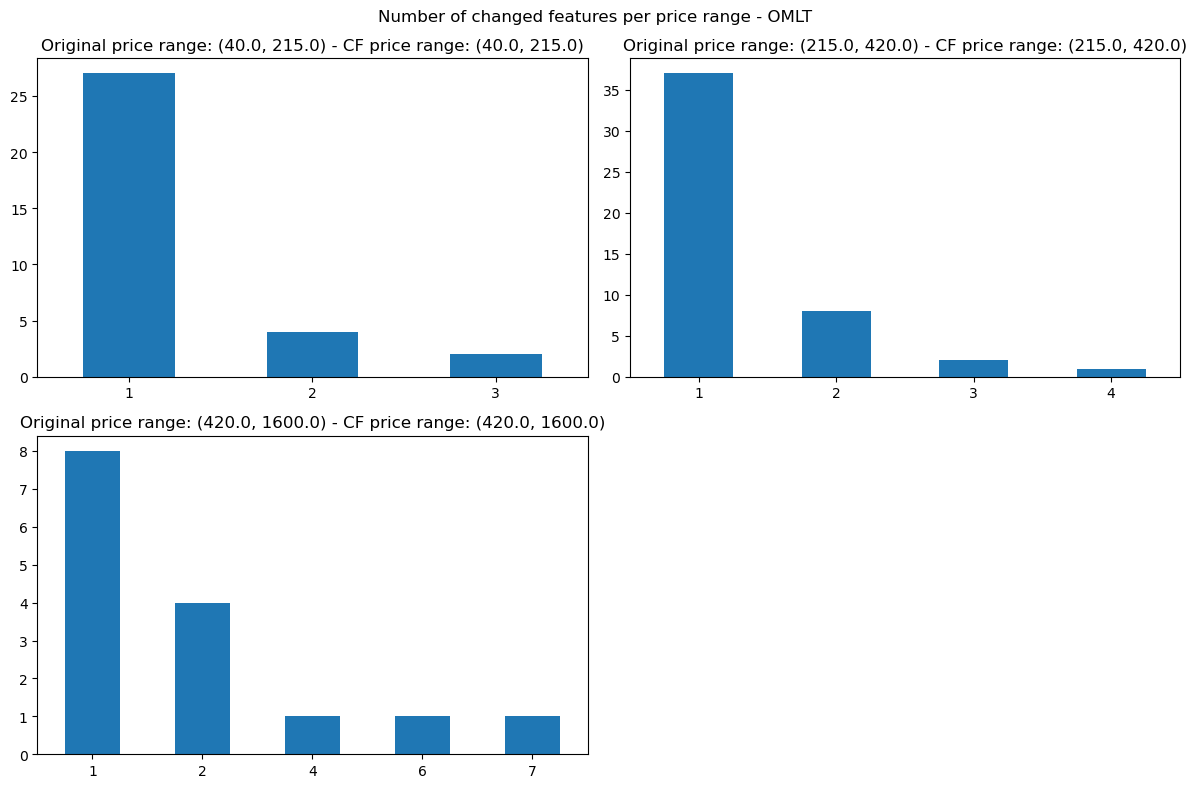

In [102]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - OMLT", figsize=(12, 8)
)

Let's check if the features changed by the model are different from before.

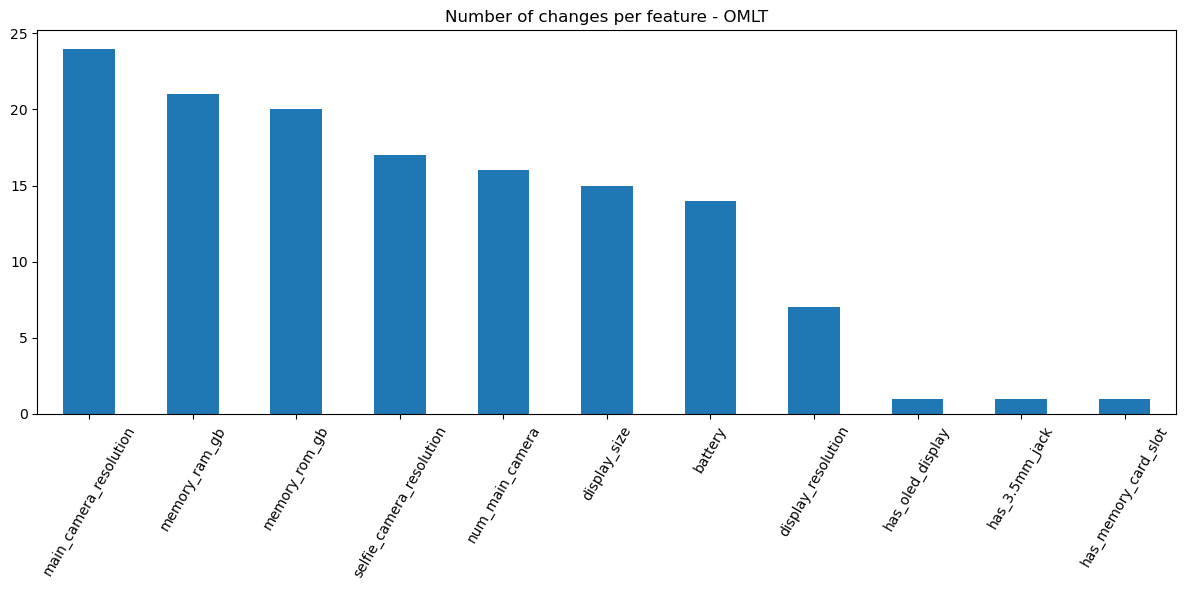

In [108]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - OMLT", figsize=(12, 6)
)

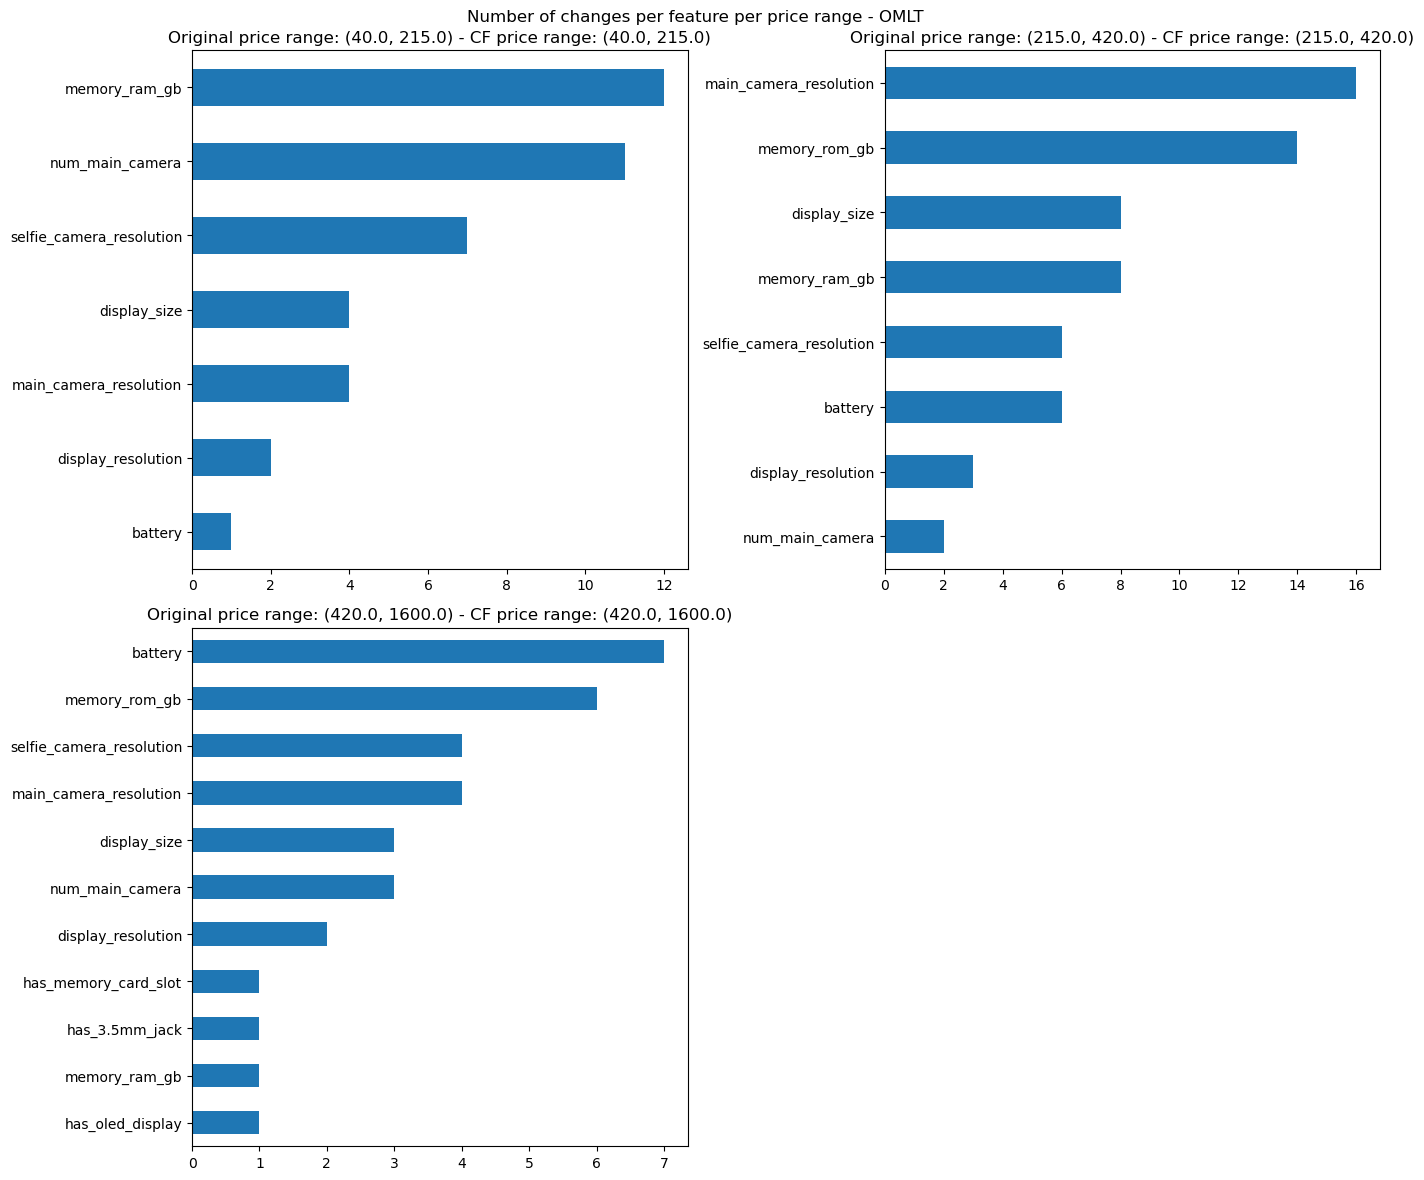

In [104]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - OMLT", figsize=(14, 12)
)

The most changed features are equal to the one changed before, and the we can conclude the same thing for the distribution of the histograms.

### DiCE

In [110]:
df_cf_dice_mis = pd.read_csv("data/counterfactual/wrong_cf_dice.csv", index_col=0)
df_cf_dice_mis = util_evaluation.cast_round_type(df_cf_dice_mis, df_test_den.dtypes.to_dict())
df_cf_dice_mis.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
868,215.0,420.0,5.5000,3000.0000,3.0,32.0,16.0,8.0,FHD,4G,1.0,0,0,0,0,1,0,0,0
771,420.0,1600.0,6.3652,4499.9999,8.0,128.0,48.0,12.0,FHD,4G,3.0,1,0,0,1,1,1,0,0
1672,215.0,420.0,5.5000,4010.0000,4.0,64.0,13.0,16.0,FHD,4G,1.0,0,1,0,1,1,0,0,0
1597,40.0,215.0,6.0061,4000.0000,3.0,32.0,12.0,13.0,FHD,4G,2.0,0,1,0,1,1,0,0,0
1030,215.0,420.0,6.0061,3250.0000,4.0,64.0,12.0,12.0,FHD,4G,2.0,1,1,0,1,1,0,0,0


In [116]:
print(f"Number of counterfactuals found by DiCE for misclassified samples: {df_cf_dice_mis.shape[0]}/{len(wrong_ind)}")

Number of counterfactuals found by DiCE for misclassified samples: 95/96


In [112]:
merge_df_dice_mis = util_evaluation.join_merge_columns(df_cf_dice_mis, df_test_den, ["misc_price_min", "misc_price_max"])

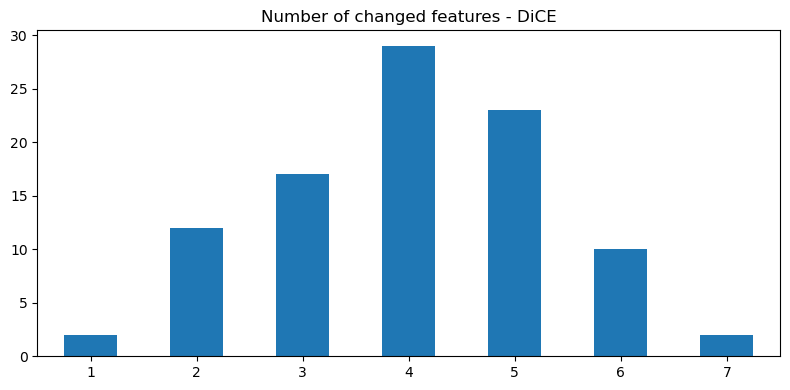

In [113]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - DiCE", split_ranges=False, figsize=(8, 4)
)

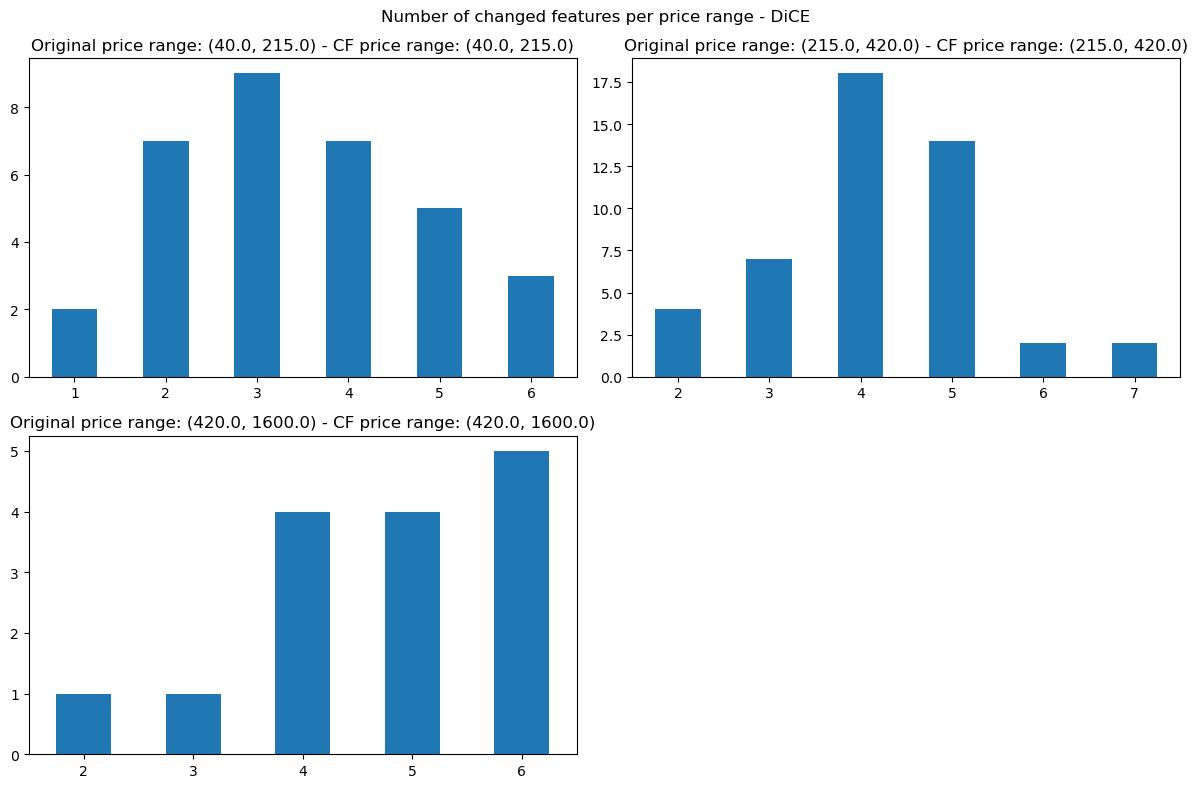

In [114]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - DiCE", figsize=(12, 8)
)

DiCE also changes a higher number of features than OMLT for the misclassified example, but it will probably lead to generate counterfactuals that are similar to existent devices (more changes but smoother than one single big change).

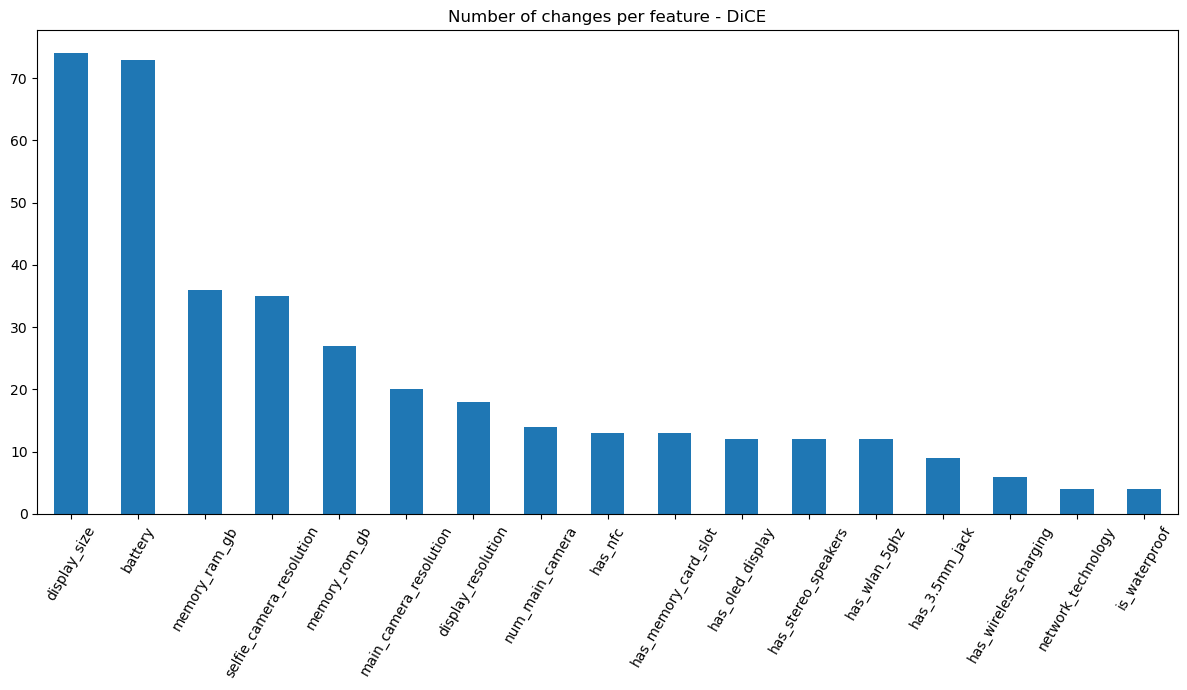

In [111]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - DiCE", figsize=(12, 7)
)

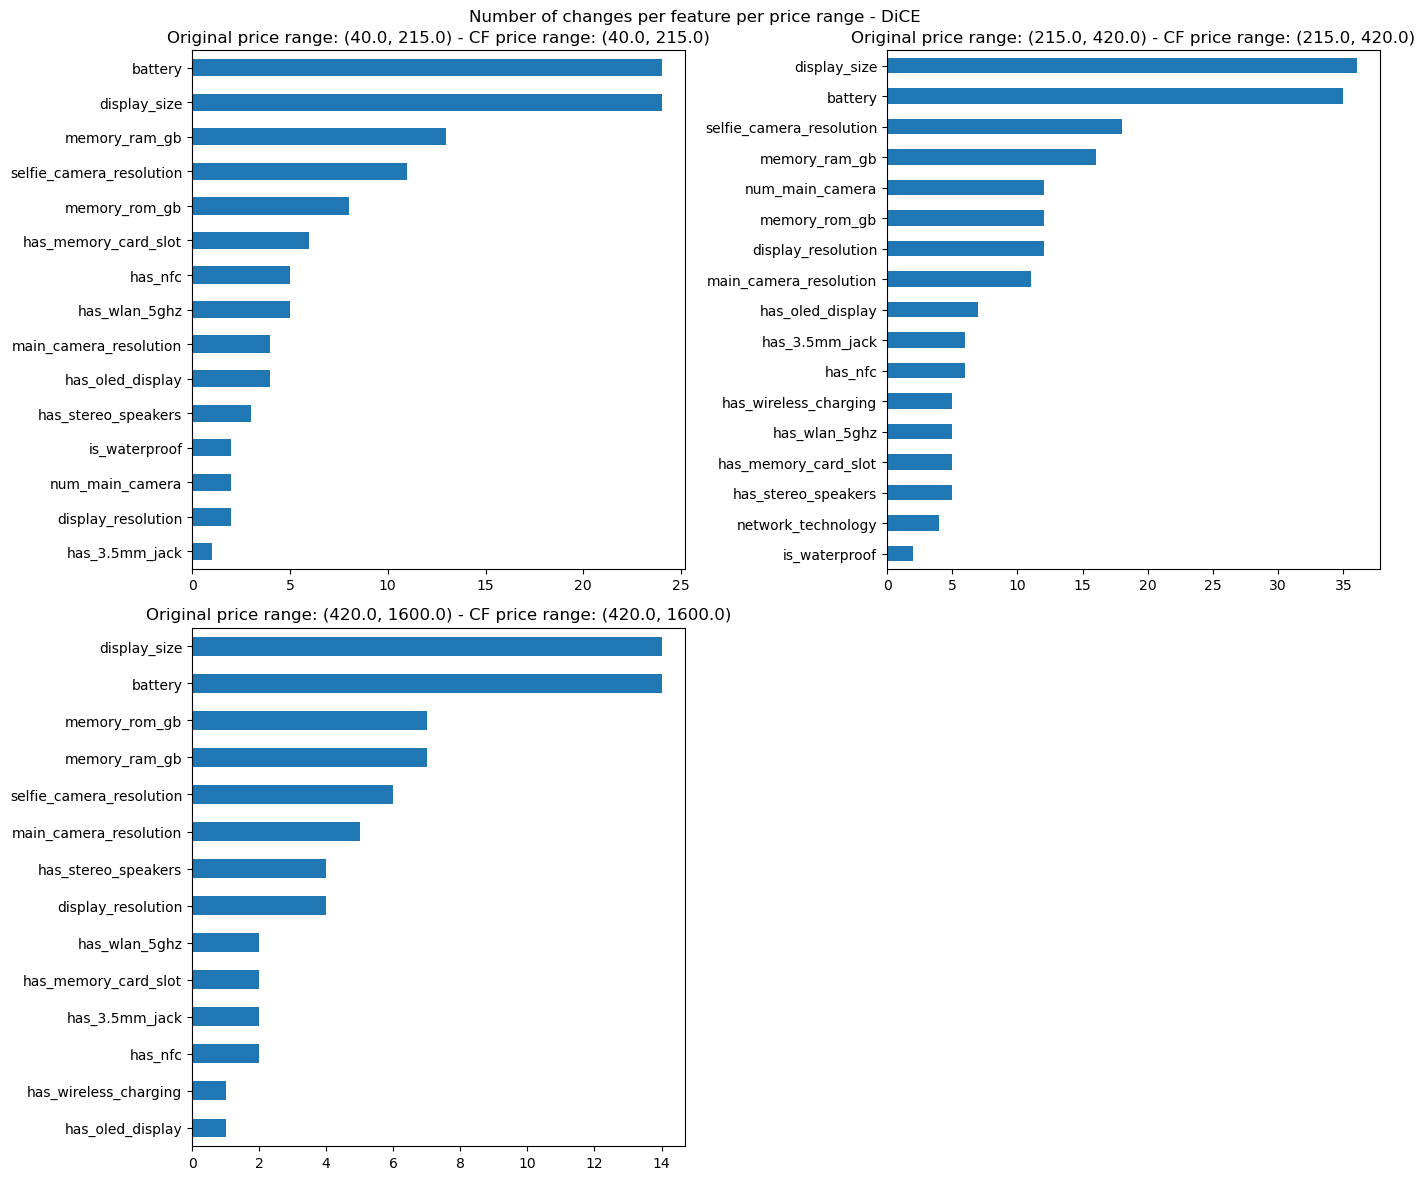

In [112]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - DiCE", figsize=(14, 12)
)

We can conclude that both, OMLT and DiCE, work in a similar way with the misclassified and the correct samples. 

They change almost the same features, the data have the same distribution and the results are similar. The only differences are the magnitude of the changes and the number of changed features, that is reduced a bit for the misclassified samples.

It may be predictable since the problem of getting the model to classify correctly a "wrong" sample, seems easier than passing from the correct label to a different one.

We can also confirm this hypothesis checking the number of found counterfactuals (almost all the tested ones for both), that is very high compared to the results obtained on the correctly classified samples.

## Further experiments on counterfactual generation

In [119]:
from utils.util_counterfactual import generate_counterfactuals_from_sample_list
from utils import util_models

import torch

To further test the capabilities of our models, we decided to fix some features, such that they cannot be changed during the counterfactual generation, and we give some customized weights to the features. In the following cells we discuss the obtained results with both DiCE and OMLT.

In [120]:
# Import the training dataset, that we need to initialize some functions.
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
X_train, y_train = df_train.drop('misc_price', axis=1), df_train['misc_price']

Compute the lists of categorical and continuous features. 

In [121]:
cont_feat = [
    "display_size", "battery", "memory_ram_gb", 
    "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
cat_feat = X_train.columns.drop(cont_feat).tolist()

cont_feat = [(X_train.columns.get_loc(feat), feat) for feat in cont_feat]
cat_feat = [(X_train.columns.get_loc(feat), feat) for feat in cat_feat]

print(f"Continuous features: {cont_feat}\n")
print(f"Categorical features: {cat_feat}")

Continuous features: [(0, 'display_size'), (1, 'battery'), (2, 'memory_ram_gb'), (3, 'memory_rom_gb'), (4, 'main_camera_resolution'), (5, 'selfie_camera_resolution')]

Categorical features: [(6, 'display_resolution'), (7, 'network_technology'), (8, 'num_main_camera'), (9, 'has_oled_display'), (10, 'has_memory_card_slot'), (11, 'has_stereo_speakers'), (12, 'has_3.5mm_jack'), (13, 'has_wlan_5ghz'), (14, 'has_nfc'), (15, 'has_wireless_charging'), (16, 'is_waterproof')]


Set the default values for the OMLT and DiCE options.

In [123]:
kwargs_cf_dice = {
    "target" : "misc_price",
    "n_cf" : 1,
    "verbose": False
}

solver_opt = {
    "mip display": 0,
    "timelimit": 60
}
kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 1, 0.3],
    "solver": "cplex",
    "solver_options" : solver_opt,
    "verbose": False
}

### Further experiments - fix some features

We know that the most changed features in DiCE are ***battery***, ***display_size***, ***memory_ram_gb***, ***selfie_camera_resolution***, ***memory_rom_gb*** and ***main_camera_resolution***. 

For the OMLT model the list of features is the same but in addition there is ***display_resolution***.

For this reason it seems reasonable to fix these features in different combinations and try to understand how the models behave.

In [150]:
features_to_fix_dice = ['battery', 'display_size', 'memory_ram_gb', 'selfie_camera_resolution', 'memory_rom_gb', 'main_camera_resolution']
features_to_fix_omlt = ['memory_ram_gb', 'selfie_camera_resolution', 'display_size']

weights = np.repeat(1, len(cont_feat) + len(cat_feat))
print(f"Sum of weights: {np.sum(weights)} with {len(weights)} weights.")

feature_props_dice = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights, to_fix=features_to_fix_dice)
# feature_props_omlt = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights, to_fix=features_to_fix_omlt)
feature_props_omlt = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights, to_fix=features_to_fix_omlt)

Sum of weights: 17 with 17 weights.


Our analysis is performed on the correctly predicted samples, therefore we take some indexes from the "corr_ind" list. 

Examples: 314, 1861, 1339, 664, 918, 696

In [131]:
idx = 314

sample_idx = X_test.loc[[idx]]
label_idx = y_test.loc[[idx]]
print(f"The label for this sample is {label_idx[idx]}.")

The label for this sample is 1.


**DiCE**

DiCE generate a counterfactual with the desired fixed features, but with a small numerical error on some continuous features (~ $1 e^{-4}$).

In [143]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, sample_idx, label_idx, feature_props=feature_props_dice,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

[0] Generating counterfactual for sample 314.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]

Time elapsed: 0.3469226360321045 seconds.


In [144]:
print(f"The sample to evaluate, with label {label_idx[idx]}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label 1, is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,25.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The generated counterfactual is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4049.999973,4.0,63.999999,25.0,13.0,FHD,4G,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


Even if we tell the model not to change some features, there is a small error in the computation (~ $1e^{-4}$) but this is normal and it is as if the model kept the same value.

**OMLT**

Using the OMLT model, we fix only ***memory_ram_gb***, ***selfie_camera_resolution*** and ***display_size*** otherwise it is not able to generate a counterfactual if the fixed features are too much.

In [151]:
cfs = generate_counterfactuals_from_sample_list(
    nn_model, "omlt", X_train, y_train, sample_idx, label_idx, feature_props_omlt, 
    type_cf="lower", target_column="misc_price", pipeline=cols_pipeline, save_filename=None, **kwargs_cf_omlt
)

[0] Generating counterfactual for sample 314.
Time elapsed: 25.239737510681152 seconds.


In [152]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,25.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The generated counterfactual is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4050.0,4.0,64.0,19.0,13.0,FHD,4G,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In the counterfactual we can see that the only changed features are ***num_main_camera*** and ***main_camera_resolution***.

### Change the weights of the features

First of all we check what is the default counterfactual generated by the model (DiCE or OMLT) using the same weights for each element, then we test if increasing the weights for some features, the model doesn't change them anymore (or it changes it less).

In this case we increase the weights of ***memory_rom_gb*** to 2.5 and ***main_camera_resolution*** to 4 and we let the others to 1.

In [216]:
# Set all the weights to 1
weights = np.repeat(1, len(cont_feat) + len(cat_feat))
feature_props = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights)

In [213]:
# Set some features with different weights
weights[X_train.columns.get_loc("memory_rom_gb")] = 2.5
weights[X_train.columns.get_loc("main_camera_resolution")] = 4

feature_props_w = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights)

**DiCE**

In [209]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, sample_idx, label_idx, feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

[0] Generating counterfactual for sample 314.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]

Time elapsed: 0.2612030506134033 seconds.


In [214]:
cfs_w = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, sample_idx, label_idx, feature_props=feature_props_w,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

[0] Generating counterfactual for sample 314.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]

Time elapsed: 0.29164671897888184 seconds.


In [215]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe counterfactual computed with the same weights is:")
display(cfs)
print("\nThe generated counterfactual with different weights is:")
display(cfs_w)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,25.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The counterfactual computed with the same weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.36,4000.000042,3.0,32.0,16.0,13.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0



The generated counterfactual with different weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.21,3399.999961,4.0,63.999999,24.0,8.0,FHD,4G,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


After the increase of the weights the DiCE model changes ***display_size*** more than ***battery***.

**OMLT**

The OMLT model changes different features than before, therefore we increase in this case the ***memory_ram_gb*** and ***main_camera_resolution*** weights.

In [220]:
# Set some features with different weights
weights = np.repeat(1, len(cont_feat) + len(cat_feat))

weights[X_train.columns.get_loc("memory_ram_gb")] = 4
weights[X_train.columns.get_loc("main_camera_resolution")] = 2.5

feature_props_w = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights)

First we generate the counterfactual with all the weights equal to one.

In [217]:
cfs = generate_counterfactuals_from_sample_list(
    nn_model, "omlt", X_train, y_train,sample_idx, label_idx, feature_props, 
    type_cf="lower", target_column="misc_price", pipeline=cols_pipeline, save_filename=None, **kwargs_cf_omlt
)

[0] Generating counterfactual for sample 314.
Time elapsed: 16.74634861946106 seconds.


Then the counterfactual with the different weights.

In [221]:
cfs_w = generate_counterfactuals_from_sample_list(
    nn_model, "omlt", X_train, y_train,sample_idx, label_idx, feature_props_w, 
    type_cf="lower", target_column="misc_price", pipeline=cols_pipeline, save_filename=None, **kwargs_cf_omlt
)

[0] Generating counterfactual for sample 314.
Time elapsed: 61.62643885612488 seconds.


In [222]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe counterfactual computed with the same weights is:")
display(cfs)
print("\nThe generated counterfactual with different weights is:")
display(cfs_w)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,25.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The counterfactual computed with the same weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4050.0,1.5,64.0,19.0,13.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0



The generated counterfactual with different weights is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4050.0,4.0,16.0,19.0,13.0,qHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


Also the OMLT model works as predicted, stopping to decrease the memory ram and changing the rom instead.